### CH4. Model Training
#### INTRO
- 지금까지 RNN, CNN, DNN등의 neural network들의 구조에 대해서 배웠고 직접 여러가지 실습및 분석도 해 보았지만 모델을 학습 시킬때에 항상 무언가 허술한 부분이 있다는 생각이 들었다.
    - 예를 들면 CNN을 이용 할 때에 모델 설계와 데이터 전처리까지 잘 해 놓고도 마지막에 분류 문제인데 crossentropy를 쓰지 않는다든가의 실수를 저질러서 학습이 잘 안되는 경우나 activation이나 optimizer을 제대로 data의 scale에 맞추지 않는 것 때문에 문제가 발생하는 경우가 있었다.
- 그래서 어떻게 training이 진행이 되는지 그 원리를 좀더 공부해 보고자 했다.
- 특히나 keras API를 정말 이용만 했었지 그 수학적인 논리를 알면 나중에 학습시킬때에 방법을 선택하기가 더 쉬울 것이라는 생각이 들었다.

In [2]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

### 1. 선형 회귀 
#### 1-1. 선형 회귀에 사용되는 반복적인 최적화 방식들
- 경사 하강법 (GD)
- 배치(batch) 경사 하강법
- 미니 배치 (mini-batch) 경사 하강법
- 확률적(stochastic) 경사 하강법 (SGD)  

**일반적으로 선형 모델은 입력 특성의 가중치 합과 편향(bias)라는 상수를 더해서 예측을 만든다.**
- 모델을 훈련 시킨다는 것은 곧 **모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것**을 의미한다.
- 회귀에 가장 널리 사용되는 성능 측정 지표는 평균 제곱근 오차 (RMSE)이다.
    - 따라서 선형 회귀 모델을 훈련시키기 위해서는 RMSE값을 최소화하는 theta값을 찾아야 한다.
    - 물론 평균 제곱 오차 (MSE)를 최소화 하는 theta값을 찾는 것이 더 간단하기는 하다.  
    
    
**theta의 최소화를 위한 방법**  


**1. 정규 방정식 (Normal Equation)**
- (비용함수를 최소화 하는 theta) = (x 벡터의 traverse * x 벡터)^-1 * (x 벡터의 traverse) * (y)
- 이 공식을 시험해 보기 위해서 선형의 임의의 데이터를 생성해 보기로 하자.

In [3]:
x = 2 * np.random.rand(100,1)
y = 4 + 3 * x + np.random.randn(100, 1)

Text(0, 0.5, 'y')

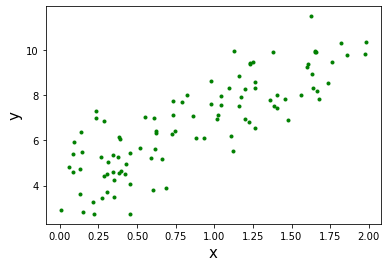

In [4]:
plt.plot(x, y, "g.")
plt.xlabel('x', fontsize = 15)
plt.ylabel('y', fontsize = 15)

In [5]:
#numpy 선형 대수 모듈인 np.linalg를 사용해서 역행렬을 구해주고 dot()를 이용해서 행렬 곱셈을 한다.
#모든 샘플에 X0값으로 1을 추가해 준다.
#x.T는 x의 traverse이다.
x_b = np.c_[np.ones((100,1)), x]
best_theta = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [6]:
best_theta

array([[4.00819138],
       [3.13450384]])

In [30]:
#실제로 예측하기를 바랬던 값은 편향인 4와 기울기인 3이었지만 매우 가깝게 나왔다.
#이를 이용해서 예측을 해보면
x_new = np.array([[0],[2]])
x_new_b = np.c_[np.ones((2,1)), x_new]
y_predict = x_new_b.dot(best_theta) 
y_predict

array([[ 4.00819138],
       [10.27719907]])

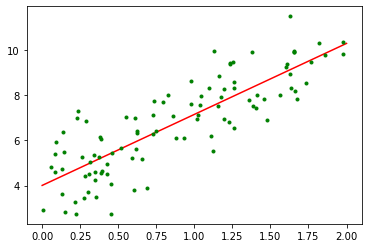

In [8]:
plt.plot(x_new, y_predict, 'r-')
plt.plot(x,y,'g.')
plt.show()

이렇게 numpy로 진행하면 뭔가 복잡해 보일 수 있으나 sklearn으로 선형 회귀를 수행하는 것은 비교적 간단하다.

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.00819138]), array([[3.13450384]]))

In [10]:
lin_reg.predict(x_new)

array([[ 4.00819138],
       [10.27719907]])

- sklearn의 LinearRegression은 SVD (특잇값 분해)의 방법을 사용해서 최고의 theta를 구하고 예측을 한다.
- 이 방법 뿐 아니라 정규 방정식을 이용해서 학습된 선형 회귀 모델은 예측이 매우 빠르며, 예측 계산의 복잡도는 샘플 수와 특성의 수에 선형적이다.
- 이 방법은 따라서 특성이 너무 많고 훈련 샘플이 너무 많아서 메모리에 담을 수 없을 때에 사용하기에는 느릴 수 있어 적합하지 않을 확률이 높다.
    - 이제 다뤄볼 방법은 경사 하강법 (Gradient Descent)이다.  
    
    
#### 2. 경사 하강법(Gradient Descent)
- 메모리의 크기가 크고 특성이 많을 때에 적합한 방법이다.
- 이는 여러 종류의 문제에서 최적의 해법을 찾는데 이용되는 방법이다.
    - 기본 아이디어는 **비용 함수를 최소화 하기 위해서 반복적으로 parameter의 값을 조정**하는 것이다.  
2-1. 파라미터 벡터 theta에 대해서 비용 함수의 현재 gradient를 계산  
2-2. gradient가 감소하는, 결국 비용이 작아지는 방향으로 진행 (gradient는 결과적으로 함숫값의 변화량이기 때문)  
2-3. gradient = 0이 되면 비용은 최솟값에 도달하게 되는 것이다.  

- 중요한 것은 경사하강법을 진행함에 있어서 비용함수가 볼록 함수여야 한다는 것이다.
    - 물론 선형 회귀에 사용이 되는 비용함수인 MSE는 볼록함수는 맞기 때문에 learning rate만 너무 크지 않다면 충분히 parmeter이 최솟값에 수렴할 수 있다.
    - 그러나 경사 하강법을 진행할 때에는 **모든 특성이 반드시 같은 scale을 가져야**한다.
        - 이를 위해서 sklearn의 StandardScaler을 이용하는 방법이 존재한다. 
            - 이는 데이터의 각 특성에서 평균을 빼고 표준편차로 나누어 표준 정규 분포의 형태로 만들어 준다,  


**경사 하강법을 이용할 때에 특성을 표준화 하는데에는 다 이유가 있었다. 데이터를 같은 scale, 즉 수치의 범위를 일치해 주어야 경사 하강법 알고리즘이 최솟값에 빠르게 도달이 가능하다.**

**2-1. 배치 경사 하강법**
- 각각의 model의 parameter에 대해서 비용함수의 편도 함수를 구해 주어야 한다.
- 이는 parameter로 비용함수인 (여기서는 MSE) 를 편미분한 값으로, theta가 변경될 때마다 손실함수의 값이 얼마나 변하는지를 알려준다.
- 따라서 위로 향하는 gradient vector이 구해지면 아래로 내려가야 하는데 theta에서 gradient값을 빼주어야 한다.
    - 여기서 step size를 구하는데 사용되는 것이 learning rate이다.

In [58]:
lr1, lr2, lr3 = 0.0001, 0.1, 0.6
n_steps = 1000
m = 100

theta1 = np.random.randn(2,1)
theta2 = np.random.randn(2,1)
theta3 = np.random.randn(2,1)

for i in range(n_steps):
    gradient1 = 2/m * (x_b.T.dot(x_b.dot(theta1) - y))
    theta1 -= gradient1 * lr1
    gradient2 = 2/m * (x_b.T.dot(x_b.dot(theta2) - y))
    theta2 -= gradient2 * lr2
    gradient3 = 2/m * (x_b.T.dot(x_b.dot(theta3) - y))
    theta3 -= gradient3 * lr3
    

In [59]:
theta1, theta2,theta3

(array([[1.71867149],
        [0.54648087]]),
 array([[4.00819138],
        [3.13450384]]),
 array([[-8.31264061e+106],
        [-8.58794144e+106]]))

Text(0.5, 1.0, 'learning_rate = 0.6')

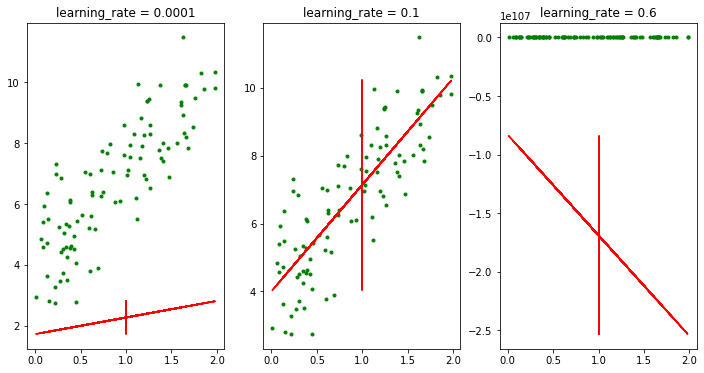

In [61]:
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
plt.plot(x,y,'g.')
y_predict = x_b.dot(theta1)
plt.plot(x_b,y_predict,'r-')
plt.title('learning_rate = 0.0001')
plt.subplot(1,3,2)
plt.plot(x,y,'g.')
plt.plot(x_b, x_b.dot(theta2),'r-')
plt.title('learning_rate = 0.1')
plt.subplot(1,3,3)
plt.plot(x,y,'g.')
plt.plot(x_b, x_b.dot(theta3), 'r-')
plt.title('learning_rate = 0.6')

- 위의 여러 학습률에 따른 경사 하강법의 결과를 보게 되면 왼쪽은 너무 낮고, 오른쪽은 학습률이 너무 높다. 일단 왼쪽은 너무 낮아서 최적점에 도달하는데에 시간이 너무 오래 걸릴 것이다.
- 적절한 학습률을 찾기 위해서는 grid 탐색을 이용하는데,   
```from sklearn.model_selection import GridSearchCV```를 이용한다. 물론 sklearn에서 제공하는 함수인 RandomForestRegressor, LinearRegression등을 사용해야 적용이 쉽게 가능하지만 일반적으로 keras로 구현한 model에도  

```
tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=None, sk_params
)
```   


```
tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=None, sk_params
)
```  
를 이용해서 사용이 가능하다.

- 반복 횟수 또한 중요한 변수인데 너무 작으면 최적점에 도달하기 전에 알고리즘이 멈출 수 있다. 또한 너무 크면 파라미터가 더는 변하지 않을 수 있다.
- 따라서 **반복횟수를 크게 지정하고 gradient vector의 값이 아주 작아지면, 즉 vector의 norm이 허용오차보다 작아지면 알고리즘을 중지**하도록 하는 방법으로 해결이 가능하다.

#### 2-2. 확률적 경사 하강법 (SGD)
- 배치 경사 하강법이 매 스텝에서 전체 훈련 세트를 이용해서 gradient를 계산하는 것과 달리 매 스텝에서 한 개의 sample을 무작위로 선택하고 그 하나의 sample에 대해 gradient를 계산한다.
- 그러나 확률적, 즉 무작위적이기 때문에 훨씬 불안정적이고 최솟값에 안착하는 것은 불가능하다.
    - 이를 해결하기 위해서 학습률을 점진적으로 감소 시킬 수 있다.
    - 매 반복에서 학습률을 결정지어주는 함수를 learning rate schedule 이라고 한다.
    

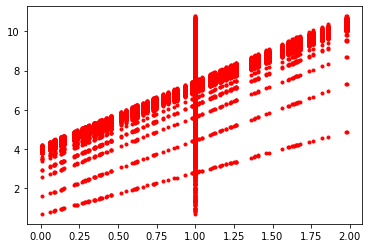

In [68]:
m,n_epoch = 100,50
t0,t1 = 5,50 #learning rate schedule parameters

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epoch):
    for i in range(m):
        random_index = np.random.randint(m)
        x_random = x_b[random_index:random_index+1]
        y_random = y[random_index:random_index + 1]
        gradient = 2 * x_random.T.dot(x_random.dot(theta)-y_random)
        learning_rate = learning_schedule(m*epoch + i)
        theta = theta - learning_rate * gradient
        if i < 10:
            plt.plot(x_b, x_b.dot(theta), 'r.')
        
    

- 위와 같이 10개의 step을 표현해 보았는데, 아무래도 step이 조금 불규칙하게 진행됨을 확인할 수 있다.
- 샘플은 무작위로 선택이 되는 값이기 때문에 epoch마다 모든 sample을 이용할 수 있도록 하기 위해서 훈련 data를 shuffle하고 하나씩 섞을 수 있다. (그러나 이렇게 하면 수렴 속도가 늦다는 단점이 있다.)
- sklearn에서 SGD를 이용해서 선형 회귀를 사용하려면 MSE를 손실 함수로 이용하는 SGD Regressor class를 이용한다. 

In [69]:
from sklearn.linear_model import SGDRegressor
#tol는 loss의 한계점, eta0는 학습률이다
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(x, y.ravel())


SGDRegressor(eta0=0.1, penalty=None)

In [70]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.08248755]), array([3.19237863]))

- 물론 이렇게 sklearn을 이용하는 것 뿐만 아니라 keras를 사용하는 것도 당연히 가능하다.
- keras에서는 SGD가 optimizer이고, losses로 mean_squared_error을 선택해 주면 되는 것이다.

In [81]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax', input_shape = [10,10]))
#lr은 학습률, decay는 업데이트마다 감소되는 학습률의 정도, momentum은 흔들림을 감소하기 위한 SGD를 가속화 하는 값, nesterov는 nesterov momentum을 결정짓는 값
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = 'MSE', optimizer = 'sgd')

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10, 10)            110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


- 위와 같은 방법으로 model에 적용하고 싶은 경우라면 손실 함수로 MSE를 사용하고 optimizer, 즉 parameter을 수정하는 방법으로 stochastic gradient descent를 사용하면 된다.

#### 2-3. 미니 배치 경사 하강법
- 각 step에서 전체 훈련법이나 하나의 sample을 기반으로 훈련을 하는 것이 아니라 mini batch라는 sample set를 이용해서 gradient값을 계산한다.
- 이는 앞선 두 경사 하강법들과는 달리 최솟값 부근에 수렴만 하는 것이 아니라 아얘 도달할 수 있으며 배치 경사 하강법보다는 불안정함도 어느정도의 batch size를 갖는다면 훨씬 적지만, 매 step마다 많은 시간이 소요되기 때문에 다른 경사 하강법들의 parameter을 적절히 조절하여 최솟값에 도달하도록 하는 것도 좋은 방법이다.

### 3. 다항 회귀 (polynominal regression)
- 비선형 데이터 또한 학습 하는데에 선형 모델을 추가 하는 것이 가능하다.
- 예를 들면 

### 연습문제 12번. 
#### 조기 종료를 이용한 배치 경사 하강법으로 softmax regression을 구현해 보시오. (sklearn을 이용하지 않고)

In [85]:
from sklearn import datasets
iris = datasets.load_iris()

In [86]:
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [120]:
x = iris['data'][:,(2,3)] #꽃잎의 길이와 넓이에 대한 정보만 사용
y = iris['target']

In [121]:
#xo = 1인 편향을 추가해 준다.
biased_x = np.c_[np.ones([len(x), 1]), x]

In [122]:
#y의 데이터를 one-hot으로 변경해 주어야 한다.
def one_hot(data):
    n_classes = max(data)+1
    one_hot = np.zeros((data.shape[0],n_classes))
    one_hot[np.arange(len(data)), y] = 1
    return one_hot

In [123]:
from sklearn.model_selection import train_test_split
y = one_hot(y)
x_train, x_test, y_train, y_test = train_test_split(biased_x, y, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [127]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape

((96, 3), (30, 3), (24, 3), (96, 3))

In [125]:
np.exp(4)

54.598150033144236

In [131]:
def softmax(logits):
    return np.exp(logits)/np.sum(np.exp(logits),axis=1,keepdims = True)

In [135]:
n_epochs = 5000
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]
m = len(x_train)
learning_rate = 0.01
epsilon = 1e-7
theta = np.random.randn(n_inputs, n_outputs)

for i in range(n_epochs):
    logits = x_train.dot(theta)
    predict = softmax(logits)
    loss = -np.mean(np.sum(y_train * np.log(predict + epsilon), axis = 1))
    error = predict - y_train
    if i %500 == 0:
        print('Epoch : {} Loss : {}'.format(i+1, loss))
    gradient = 1/m * x_train.T.dot(error)
    theta = theta - gradient * learning_rate

Epoch : 1 Loss : 4.593076614221727
Epoch : 501 Loss : 0.9602736369471937
Epoch : 1001 Loss : 0.7410453299227574
Epoch : 1501 Loss : 0.6171289805202439
Epoch : 2001 Loss : 0.5426183063604421
Epoch : 2501 Loss : 0.4930338656016726
Epoch : 3001 Loss : 0.4570868125134712
Epoch : 3501 Loss : 0.4293444881500382
Epoch : 4001 Loss : 0.4069602104472108
Epoch : 4501 Loss : 0.38831088896251903


In [152]:
np.argmax(y_val, axis = 1)

array([0, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 1, 0,
       0, 2], dtype=int64)

In [153]:
logits = x_val.dot(theta)
predict = np.argmax(softmax(logits), axis = 1)
y_val = np.argmax(y_val, axis = 1)
accuracy = np.mean(predict == y_val)

In [154]:
accuracy

0.9583333333333334

**위의 결과의 정확도가 95.83%로 매우 높게 나온다는 사실을 알 수 있다.**

- 이제 early stopping과 l2규제를 추가해 본다면 어떻게 되는지 확인해 보자. 
    - early stopping은 검증 에러가 최소에 도달하는 순간에 멈추는 것이다.

In [160]:
learning_rate = 0.1
n_epochs = 5000
epsilon = 1e-7
learning_rate = 0.01
theta = np.random.randn(n_inputs, n_outputs)
alpha = 0.1
best_loss = np.infty

for i in range(n_epochs):
    logits = x_train.dot(theta)
    predict = softmax(logits)
    loss = -np.mean(np.sum(y_train * (predict + epsilon), axis = 1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = loss + alpha * l2_loss
    error = (predict - y_train)
    gradient = 1/m * (x_train.T.dot(error))
    theta = theta - gradient * learning_rate
    if i % 500 == 0:
        print('Epochs : {} Loss : {}'.format(i+1, loss))
    if loss < best_loss:
        best_loss = loss
    else:
        print('Epochs : {} Loss : {} Early Stopping!'.format(i+1, loss))
        break
    
    


Epochs : 1 Loss : 0.0956124747248927
Epochs : 501 Loss : -0.10199674941861953
Epochs : 1001 Loss : -0.2082214810020263
Epochs : 1501 Loss : -0.2708948265455106
Epochs : 2001 Loss : -0.3063116393140716
Epochs : 2501 Loss : -0.32491607149813656
Epochs : 3001 Loss : -0.33277444071328116
Epochs : 3305 Loss : -0.33388838002506277 Early Stopping!


In [172]:
logits = x_val.dot(theta)
predict = np.argmax(softmax(logits), axis = 1)
accuracy = np.mean(predict == y_val)

In [168]:
predict

array([0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1, 0,
       0, 2], dtype=int64)

In [169]:
y_val

array([0, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 1, 0,
       0, 2], dtype=int64)

In [173]:
accuracy

0.9166666666666666

**이렇게 l2규제와 조기 종료까지 포함한 이후의 정확도는 91.66%였다.**
- 이상하게도 규제를 적용하지 않았을 때가 더 높은 정확도를 보인다.
- 이 규제를 사용하는 이유는 과대 적합을 방지하기 위해서인데, l2규제는 비용함수에 규제항이 추가 되어 모델의 가중치를 최대한 작게 유지하기 위해서 사용한다.
- 규제항은 훈련하는 동안에만 비용함수에 추가가 되거, 모델의 훈련이 끝나면 규제가 없는 성능 지표로 평가하게 된다.
- 그런데 아마 데이터셋의 성능이 떨어진 이유는 데이터셋의 크기가 작기 때문일 것이라고 생각한다.

### 결론
1. 앞으로는 어떤 model을 compile과 fit하는 작업을 진행할 때에 데이터의 형태와 선형분류인지, 회귀인지, 다항 분류인지, 회귀인지등의 목적을 따져 가면서 loss와 optimizer을 좀더 신중하게, 그리고 정확하게 선택할 수 있을 것이라 기대한다.